# 03a — Phase‑1 Alignment Retrieval Evaluation

This notebook evaluates **Phase‑1 aligned encoders** for retrieval and alignment quality.

It supports two kinds of aligned models:

1. **Vision–Text** alignment (`VisionTextAligner`) – image ↔ text retrieval on PixMo‑Cap.
2. **Multimodal** alignment (`MultimodalAlignmentModel`) – image, text, and audio.

The notebook:

- Loads a **single alignment checkpoint** (vision–text *or* multimodal) and infers what kind of model it is.
- Evaluates **image↔text retrieval** (always, if encoders exist).
- Optionally evaluates **audio↔text** retrieval (if the model has audio encoders and an audio dataset is available).
- Computes rich retrieval metrics inspired by **Freeze‑Align, ImageBind, Matryoshka Multimodal Models, and Unified‑IO 2**:
  - Recall@K (K ∈ {1, 5, 10, 50})
  - Mean Rank (MR) and Median Rank (MedR)
  - mAP@K and NDCG@K
  - Matryoshka performance vs. embedding dimensionality
- Produces **plots and diagnostics** for interpreting alignment quality:
  - Rank histograms
  - CDF of ranks (how often the correct match is in top‑K)
  - Positive vs. negative similarity distributions
  - Matryoshka curves (R@K vs. dimension)

All scalar metrics and some plots are logged to **Weights & Biases** for comparative analysis across runs.


In [1]:
# === Imports & Environment Setup ===
import os
from pathlib import Path
from typing import Dict, Tuple, Optional, List

import math
import json

import numpy as np
import pandas as pd

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import load_dataset

import wandb

# Project imports
from imports.core import (
    AlignmentConfig,
    VisionTextAligner,
    VisionEncoder,
    TextEncoder,
    l2_normalize,
)
from imports.multimodal_alignment_perceiver import (
    MultimodalAlignmentModel,
    MultimodalAlignmentConfig,
)
from imports.in_memory_datasets import (
    InMemoryImageTextDataset,
    InMemoryAudioTextDataset,
    collate_in_memory_images,
    collate_in_memory_audio,
)




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cuda


## Configuration

You typically change only this cell when switching checkpoints or datasets.

- `EVAL_CKPT_PATH` – the alignment checkpoint to evaluate. The notebook will inspect it to decide whether it's a
  **vision–text** model or a **multimodal** model.
- `PIXMO_PARQUET_PATH` – the local PixMo‑Cap Parquet used for image↔text evaluation.
- `AUDIO_PARQUET_PATH` – optional local Parquet for audio↔text evaluation (e.g., Clotho). If it doesn't exist
  or the model has no audio encoder, audio eval is skipped.

The config also controls basic dataloader settings and W&B logging metadata.


In [2]:
# === Config: Paths, Checkpoints, and WandB ===
from dataclasses import asdict

# Root of your project (set EDGE_GLASS_ROOT env var or edit here)
ROOT_DIR = Path(os.environ.get('EDGE_GLASS_ROOT', '.')).resolve()
print('ROOT_DIR:', ROOT_DIR)

ROOT_DIR: /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base


In [3]:
# Alignment checkpoint to evaluate (vision–text OR multimodal)
# Example vision–text: artifacts/phase1_alignment/vision_text/vision_text_best.pt
# Example multimodal:   artifacts/phase1_alignment_multimodal/mlp_mrl/phase1_multi_mlp_best.pt
EVAL_CKPT_PATH = ROOT_DIR / 'checkpoints' / 'phase1_multimodal' / 'mlp_mrl' /'best.pt'
print('EVAL_CKPT_PATH:', EVAL_CKPT_PATH)

EVAL_CKPT_PATH: /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/checkpoints/phase1_multimodal/mlp_mrl/best.pt


In [4]:


# PixMo‑Cap parquet (image + caption) for image↔text retrieval
PIXMO_PARQUET_PATH = ROOT_DIR / 'data' / 'final_dataset' / 'pixmo' /'pixmo_test.parquet'
# Column names inside the parquet (adjust if needed)
PIXMO_IMAGE_COL = 'image_bytes'      # e.g., HF Image, image bytes, or local path
PIXMO_TEXT_COL = 'caption'     # caption string


In [5]:

# Optional audio‑caption parquet (for multimodal models with audio encoders)
# Example: data/alignment_offline/clotho_development.parquet
AUDIO_PARQUET_PATH = ROOT_DIR / 'data' / 'final_dataset' / 'clotho' / 'clotho_test.parquet'
AUDIO_AUDIO_COL = 'audio'      # waveform or path/bytes; see InMemoryAudioTextDataset
AUDIO_TEXT_COL = 'caption'     # caption string


In [6]:

# If your Parquet files contain a 'split' column, this selects the split for eval
EVAL_SPLIT = 'val'
MAX_EVAL_SAMPLES = None   # set None for full dataset

# Dataloader settings
BATCH_SIZE = 64
NUM_WORKERS = 4

# W&B configuration
WANDB_PROJECT = 'edgeglass_final_align'
WANDB_ENTITY = None  # set to your W&B entity if needed
RUN_NAME = 'final_align_perciever_1_eval'

wandb_config = {
    'eval_ckpt_path': str(EVAL_CKPT_PATH),
    'pixmo_parquet': str(PIXMO_PARQUET_PATH),
    'audio_parquet': str(AUDIO_PARQUET_PATH),
    'eval_split': EVAL_SPLIT,
    'max_eval_samples': MAX_EVAL_SAMPLES,
    'batch_size': BATCH_SIZE,
}

wandb_run = wandb.init(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    name=RUN_NAME,
    job_type='alignment_eval',
    config=wandb_config,
)

clotho_parquet_path: Path = AUDIO_PARQUET_PATH



wandb: Currently logged in as: vedaangchopra (vedaangchopra_gatech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Retrieval Metric Utilities

We implement a rich metric suite used in many retrieval papers:

- **Recall@K** (R@K) for K ∈ {1, 5, 10, 50}
- **Mean Rank** and **Median Rank** (1‑indexed)
- **mAP@K** (mean Average Precision) for K ∈ {10, 50}
- **NDCG@K** (Normalized Discounted Cumulative Gain) for K ∈ {10, 50}

Assumption: each query has a **single relevant item**, at the same index in the key set (standard for image–caption pairs).


In [7]:
# === Retrieval Metric Helpers ===

def compute_full_retrieval_metrics(
    q: Tensor,
    k: Tensor,
    ks: Tuple[int, ...] = (1, 5, 10, 50),
    map_ks: Tuple[int, ...] = (10, 50),
    ndcg_ks: Tuple[int, ...] = (10, 50),
) -> Dict[str, float]:
    """Compute rich retrieval metrics for one‑to‑one matching.

    Args:
        q: (N, D) query embeddings
        k: (N, D) key embeddings
    """
    q = l2_normalize(q)
    k = l2_normalize(k)

    sims = q @ k.t()  # (N, N)
    N = sims.size(0)
    targets = torch.arange(N, device=sims.device)

    # Sort by similarity (descending)
    _, indices = sims.sort(dim=1, descending=True)
    # ranks[i]: 0‑indexed rank of the correct match for query i
    ranks = (indices == targets.unsqueeze(1)).nonzero(as_tuple=False)[:, 1]

    metrics: Dict[str, float] = {}

    # Recall@K
    for k_val in ks:
        hit_rate = (ranks < k_val).float().mean().item()
        metrics[f'R@{k_val}'] = hit_rate * 100.0

    # Rank statistics (1‑indexed)
    metrics['mean_rank'] = (ranks.float() + 1).mean().item()
    metrics['median_rank'] = (ranks.float() + 1).median().item()

    # mAP@K – single relevant item => AP = 1 / rank if rank < K else 0
    for k_val in map_ks:
        ap = torch.where(ranks < k_val, 1.0 / (ranks.float() + 1.0), torch.zeros_like(ranks, dtype=torch.float))
        metrics[f'mAP@{k_val}'] = ap.mean().item()

    # NDCG@K – DCG = 1 / log2(rank+2) if rank < K else 0; IDCG = 1
    for k_val in ndcg_ks:
        gains = torch.where(
            ranks < k_val,
            1.0 / torch.log2(ranks.float() + 2.0),
            torch.zeros_like(ranks, dtype=torch.float),
        )
        metrics[f'NDCG@{k_val}'] = gains.mean().item()

    metrics['ranks_tensor'] = ranks
    return metrics


## Image–Text Evaluation Data (PixMo‑Cap Parquet)

We build an evaluation `DataLoader` for PixMo‑Cap from a local Parquet file created in the dataset‑building phase.
This replaces online HF loading and matches the **exact data** used for Phase‑1 alignment.


In [8]:
# === Helper: Build PixMo Image–Text Eval Dataloader (from Parquet) ===

def build_pixmo_eval_dataloader() -> DataLoader:
    assert PIXMO_PARQUET_PATH.exists(), f'PixMo parquet not found at {PIXMO_PARQUET_PATH}'

    print(f"[Eval] Loading PixMo‑Cap from parquet: {PIXMO_PARQUET_PATH}")
    pixmo_local = load_dataset(
        'parquet',
        data_files={'train': str(PIXMO_PARQUET_PATH)},
    )['train']

    print('[Eval] PixMo columns:', pixmo_local.column_names)

    if 'split' in pixmo_local.column_names:
        before = len(pixmo_local)
        pixmo_local = pixmo_local.filter(lambda ex: ex['split'] == EVAL_SPLIT)
        print(f"[Eval] Filtered by split='{EVAL_SPLIT}': {before} -> {len(pixmo_local)} samples")

    if MAX_EVAL_SAMPLES is not None:
        n = min(MAX_EVAL_SAMPLES, len(pixmo_local))
        pixmo_local = pixmo_local.select(range(n))
        print(f"[Eval] Capped PixMo eval samples to {len(pixmo_local)}")

    print('\n[Eval] PixMo example row:')
    ex0 = pixmo_local[0]
    print({k: str(v)[:80] for k, v in ex0.items()})

    dataset = InMemoryImageTextDataset(
        hf_dataset=pixmo_local,
        img_col=PIXMO_IMAGE_COL,
        txt_col=PIXMO_TEXT_COL,
        max_samples=None,
        image_size=(224, 224),
    )

    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_in_memory_images,
        pin_memory=True,
    )

    print(f"[Eval] PixMo batches: {len(dataloader)}")
    return dataloader


pixmo_eval_loader = build_pixmo_eval_dataloader()
print('PixMo eval batches:', len(pixmo_eval_loader))


[Eval] Loading PixMo‑Cap from parquet: /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/data/final_dataset/pixmo/pixmo_test.parquet
[Eval] PixMo columns: ['image_bytes', 'caption', 'image_url', 'sample_id']

[Eval] PixMo example row:
{'image_bytes': "b'\\xff\\xd8\\xff\\xe0\\x00\\x10JFIF\\x00\\x01\\x01\\x00\\x00\\x01\\x00\\x01\\x00\\x00\\xff\\xed\\x", 'caption': "The image is a grainy, low-resolution color photo featuring a man's right hand w", 'image_url': 'https://live.staticflickr.com/2835/34131349835_361a142ff0_o.jpg', 'sample_id': 'pixmo_0011025'}

📥 Pre-loading 3000 images into memory...
   Image size: (224, 224)
   Using 32 parallel workers


Loading images: 100%|██████████| 3000/3000 [00:01<00:00, 2286.04it/s]


✅ Loaded 3000 images into memory
   ⚠️  3000 images failed to load (using fallback)
[Eval] PixMo batches: 47
PixMo eval batches: 47


## Optional Audio–Text Evaluation Data

For **multimodal** models that include an audio encoder, we optionally build an audio–caption eval loader from a
local Parquet file (e.g., Clotho). If the file is missing or the model has no audio encoder, audio evaluation is skipped.


In [9]:
# === Audio–Text Eval Loader (Clotho records, same as training) ===
from typing import List, Dict, Any, Optional, Tuple
from pathlib import Path
import os
import random

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset



# Cache resamplers per original sr
_resamplers: Dict[int, torchaudio.transforms.Resample] = {}


def collate_clotho_batch(batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Collate function for ClothoAudioCaptionDataset (eval).

    - Takes variable-length waveforms at original sr (typically 44100)
    - Resamples each to 16 kHz for Whisper
    - Pads to max length in the batch
    """
    audios_16k = []
    lengths_16k = []
    captions = []
    file_names = []

    for b in batch:
        wav = b["audio"]        # Tensor [T_orig]
        sr_orig = int(b["sr"])  # e.g. 44100

        # --- resample to 16 kHz ---
        if sr_orig != 16000:
            if sr_orig not in _resamplers:
                _resamplers[sr_orig] = torchaudio.transforms.Resample(
                    orig_freq=sr_orig,
                    new_freq=16000,
                )
            wav = _resamplers[sr_orig](wav)  # [T_16k]

        audios_16k.append(wav)
        lengths_16k.append(wav.shape[0])
        captions.append(b["caption"])
        file_names.append(b["file_name"])

    # Pad to max length at 16 kHz
    max_len = max(lengths_16k)
    B = len(audios_16k)

    padded = audios_16k[0].new_zeros(B, max_len)  # (B, T_max_16k)
    for i, a in enumerate(audios_16k):
        padded[i, : a.shape[0]] = a

    return {
        "audio": padded,                                    # (B, T_max_16k)
        "audio_lengths": torch.tensor(lengths_16k, dtype=torch.long),
        "sr": 16000,                                        # now fixed to 16k
        "captions": captions,                               # list[str]
        "file_names": file_names,                           # list[str]
    }


class ClothoAudioCaptionDataset(Dataset):
    """
    Dataset reading the torch-saved Clotho records used in training.
    Each item returns a single (audio, caption) pair.
    """

    def __init__(
        self,
        records_path: str,
        pick_random_caption: bool = True,
    ) -> None:
        super().__init__()
        self.records: List[Dict[str, Any]] = torch.load(records_path)
        self.pick_random_caption = pick_random_caption

    def __len__(self) -> int:
        return len(self.records)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        item = self.records[idx]
        waveform = item["waveform"]       # torch.FloatTensor [T]
        sr = item["sr"]
        file_name = item["file_name"]
        captions = item["captions"]       # list[str]

        if self.pick_random_caption:
            caption = random.choice(captions)
        else:
            caption = captions[0]

        return {
            "audio": waveform,
            "sr": sr,
            "caption": caption,
            "file_name": file_name,
        }

CLOTHO_RECORDS_PATH = AUDIO_PARQUET_PATH
def build_audio_eval_dataloader() -> Optional[DataLoader]:
    """
    Build evaluation DataLoader for audio–text retrieval using the same
    Clotho records format + collate function as used in training.
    """
    if not CLOTHO_RECORDS_PATH.exists():
        print(f"[Eval] Clotho records file not found: {CLOTHO_RECORDS_PATH}")
        print("       Skipping audio alignment evaluation.")
        return None

    print(f"[Eval] Loading Clotho records from: {CLOTHO_RECORDS_PATH}")
    ds = ClothoAudioCaptionDataset(
        records_path=str(CLOTHO_RECORDS_PATH),
        pick_random_caption=False,  # deterministic captions for eval
    )

    n = len(ds)
    print(f"[Eval] Clotho total records: {n}")

    # Optional subsampling for speed
    if MAX_EVAL_SAMPLES is not None and n > MAX_EVAL_SAMPLES:
        idx = torch.arange(n)[:MAX_EVAL_SAMPLES]
        ds = Subset(ds, idx)
        print(f"[Eval] Using first {MAX_EVAL_SAMPLES} Clotho samples for eval")

    num_gpus = max(1, torch.cuda.device_count())
    batch_size = BATCH_SIZE * num_gpus  # match training scaling if desired

    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,                      # eval -> no shuffle
        num_workers=min(8, os.cpu_count() or 4),
        collate_fn=collate_clotho_batch,    # same collate as training
        pin_memory=torch.cuda.is_available(),
        drop_last=False,
    )

    print(f"[Eval] Clotho eval batches: {len(loader)} | batch size: {batch_size}")
    return loader


# Build the eval loader (or None if file missing)
audio_eval_loader = build_audio_eval_dataloader()


[Eval] Loading Clotho records from: /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/data/final_dataset/clotho/clotho_test.parquet
[Eval] Clotho total records: 1045
[Eval] Clotho eval batches: 17 | batch size: 64


## Loading the Aligned Model (Vision–Text or Multimodal)

We inspect the checkpoint structure to decide what kind of model we are dealing with:

- If the checkpoint contains a key like `"mm_config"`, we treat it as a **multimodal** alignment model and
  reconstruct a `MultimodalAlignmentConfig` + `MultimodalAlignmentModel`.
- Otherwise, we treat it as a **Vision–Text** alignment checkpoint and build a `VisionTextAligner` with an
  `AlignmentConfig` that mirrors the Phase‑1 training setup.

Both models expose `encode_vision` and `encode_text`; the multimodal model additionally exposes `encode_audio`.


In [10]:
# === Helper: Load Aligned Model and Detect Type ===

def load_aligned_model(ckpt_path: Path) -> Tuple[str, nn.Module, object]:
    """Load an aligned model (vision–text OR multimodal) from a checkpoint.

    Returns:
        model_kind: 'vision_text' or 'multimodal'
        model: the loaded model on the current device
        cfg:   AlignmentConfig or MultimodalAlignmentConfig
    """
    assert ckpt_path.exists(), f'Checkpoint not found: {ckpt_path}'

    print(f'[Eval] Loading checkpoint: {ckpt_path}')
    state = torch.load(ckpt_path, map_location=device, weights_only=False)

    # Heuristic: multimodal checkpoints from 02_alig_multi_mlp store 'mm_config'
    if "mm_config" in state:
        model_kind = "multimodal"
        mm_cfg_dict = state["mm_config"]
        mm_cfg = MultimodalAlignmentConfig(**mm_cfg_dict)
        mm_cfg.device = str(device)
        model = MultimodalAlignmentModel(mm_cfg).to(device)

        if "model_state" in state:
            model.load_state_dict(state["model_state"], strict=False)
        else:
            raise KeyError('Expected "model_state" in multimodal checkpoint')

        print("[Eval] Detected MultimodalAlignmentModel")
        model.eval()
        return model_kind, model, mm_cfg

    # Otherwise: assume VisionTextAligner (Phase-1 vision–text)
    model_kind = "vision_text"
    vt_cfg = AlignmentConfig(
        vision_model_name="openai/clip-vit-base-patch32",
        text_model_name="sentence-transformers/all-MiniLM-L6-v2",
        d_align=512,
        mrl_dims=[64, 128, 256, 512],
        device=str(device),
    )

    # If config was serialized, prefer it
    if "config" in state:
        cfg_obj = state["config"]
        if isinstance(cfg_obj, AlignmentConfig):
            vt_cfg = cfg_obj
        else:
            vt_cfg = AlignmentConfig(**cfg_obj)
        vt_cfg.device = str(device)

    vt_model = VisionTextAligner(vt_cfg).to(device)

    if "model_state" in state:
        vt_model.load_state_dict(state["model_state"], strict=False)
    else:
        # Backwards-compatible: adapters saved separately
        if "vision_adapter" in state:
            vt_model.vision_adapter.load_state_dict(state["vision_adapter"])
        if "text_adapter" in state:
            vt_model.text_adapter.load_state_dict(state["text_adapter"])

    print("[Eval] Detected VisionTextAligner")
    vt_model.eval()
    return model_kind, vt_model, vt_cfg


model_kind, aligned_model, aligned_cfg = load_aligned_model(EVAL_CKPT_PATH)
print('Model kind:', model_kind)
print('Config:', aligned_cfg)


[Eval] Loading checkpoint: /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/checkpoints/phase1_multimodal/mlp_mrl/best.pt
[Eval] Detected MultimodalAlignmentModel
Model kind: multimodal
Config: MultimodalAlignmentConfig(vision_model_name='openai/clip-vit-base-patch32', audio_model_name='openai/whisper-base', text_model_name='sentence-transformers/all-MiniLM-L6-v2', llm_model_name='Qwen/Qwen2.5-1.5B-Instruct', d_vision=768, d_audio=512, d_text=384, perceiver_dim=512, num_latents=64, num_perceiver_layers=4, num_attn_heads=8, perceiver_mlp_ratio=4.0, perceiver_dropout=0.1, d_align=512, mrl_dims=(64, 128, 256, 512), llm_hidden_size=1536, num_prefix_tokens=64, batch_size=32, learning_rate=0.0001, weight_decay=0.01, num_epochs=10, warmup_ratio=0.1, max_grad_norm=1.0, temperature=0.07, mrl_weight=1.0, clip_weight=0.5, seed=42, device='cuda', dtype='float32')


In [11]:
# === Frozen feature encoders for multimodal models ===
vision_encoder = None
text_encoder = None

if model_kind == "multimodal":
    # Use the same backbone families as Phase-1 training
    vision_encoder = VisionEncoder(
        model_name="openai/clip-vit-base-patch32",
        device=device,
    )
    text_encoder = TextEncoder(
        model_name="sentence-transformers/all-MiniLM-L6-v2",
        device=device,
        max_length=128,
    )

    print("[Eval] Initialized frozen VisionEncoder + TextEncoder for multimodal eval.")


[VisionEncoder] Loaded openai/clip-vit-base-patch32, hidden_size=768
[TextEncoder] Loaded sentence-transformers/all-MiniLM-L6-v2, hidden_size=384
[Eval] Initialized frozen VisionEncoder + TextEncoder for multimodal eval.


## Embedding Collection

We next define helpers to extract **aligned embeddings** for different modality pairs:

- Image ↔ Text (always, if `encode_vision` and `encode_text` exist)
- Audio ↔ Text (if `encode_audio` exists and audio data is available)


In [12]:
# === Embedding Collection Helpers ===
@torch.no_grad()
def collect_image_text_embeddings(
    model: nn.Module,
    loader: DataLoader,
    model_kind: str,
    vision_encoder: Optional[VisionEncoder] = None,
    text_encoder: Optional[TextEncoder] = None,
    max_batches: Optional[int] = None,
) -> Tuple[Tensor, Tensor]:
    """
    Collect aligned image/text embeddings for PixMo image–caption pairs.

    - For 'vision_text' models (VisionTextAligner): use model.encode_vision(images) + model.encode_text(texts)
    - For 'multimodal' models (MultimodalAlignmentModel): use CLIP + MiniLM features,
      then call model.encode_vision(features, mask) / model.encode_text(features, mask).
    """
    assert hasattr(model, "encode_vision") and hasattr(model, "encode_text"), (
        "Model must implement encode_vision and encode_text for image–text eval."
    )

    model = model.to(device)
    model.eval()

    all_img, all_txt = [], []

    for batch_idx, batch in enumerate(loader):
        images = batch["images"]      # List[PIL.Image]
        captions = batch["captions"]  # List[str]

        if model_kind == "vision_text":
            # VisionTextAligner path: raw images + text
            z_i = model.encode_vision(images)   # (B, d_align)
            z_t = model.encode_text(captions)   # (B, d_align)

        else:
            # MultimodalAlignmentModel path: CLIP + MiniLM features
            assert vision_encoder is not None and text_encoder is not None, \
                "vision_encoder and text_encoder must be provided for multimodal eval."

            # 1) Vision: CLIP patch features + mask
            v_out = vision_encoder.encode(images)
            vision_feats = v_out["feats"]        # (B, T_v, d_vision)
            vision_mask = v_out["mask"]         # (B, T_v)

            # 2) Text: MiniLM pooled -> single token sequence
            pooled_txt = text_encoder.encode(captions)  # (B, d_text)
            text_feats = pooled_txt.unsqueeze(1)        # (B, 1, d_text)
            text_mask = torch.ones(
                text_feats.size(0),
                1,
                dtype=torch.bool,
                device=text_feats.device,
            )

            # 3) Multimodal alignment model: features -> aligned embeddings
            z_i = model.encode_vision(vision_feats, vision_mask)   # (B, d_align)
            z_t = model.encode_text(text_feats, text_mask)         # (B, d_align)

        all_img.append(z_i.cpu())
        all_txt.append(z_t.cpu())

        if max_batches is not None and (batch_idx + 1) >= max_batches:
            break

    img_emb = torch.cat(all_img, dim=0)
    txt_emb = torch.cat(all_txt, dim=0)
    print("[Eval] Collected", img_emb.shape[0], "image–text pairs")
    return img_emb, txt_emb


@torch.no_grad()
def collect_audio_text_embeddings(
    model: nn.Module,
    loader: DataLoader,
    max_batches: Optional[int] = None,
) -> Optional[Tuple[Tensor, Tensor]]:
    """Collect aligned audio/text embeddings.

    Returns:
        audio_emb: (N, D), txt_emb: (N, D) or None if audio not supported.
    """
    if not hasattr(model, 'encode_audio'):
        print('[Eval] Model has no audio encoder; skipping audio eval.')
        return None
    if loader is None:
        print('[Eval] No audio eval loader; skipping audio eval.')
        return None

    model = model.to(device)
    model.eval()

    all_aud, all_txt = [], []

    for batch_idx, batch in enumerate(tqdm(loader, desc='Collecting audio–text embeddings')):
        audio = batch['audio']
        captions = batch['captions']
        
        z_aud = model.encode_audio(audio)
        z_txt = model.encode_text(captions)

        all_aud.append(z_aud.cpu())
        all_txt.append(z_txt.cpu())

        if max_batches is not None and (batch_idx + 1) >= max_batches:
            break

    aud_emb = torch.cat(all_aud, dim=0)
    txt_emb = torch.cat(all_txt, dim=0)
    print('[Eval] Collected', aud_emb.shape[0], 'audio–text pairs')
    return aud_emb, txt_emb


## Image–Text Retrieval Evaluation (PixMo)

We first evaluate image↔text retrieval using the aligned embeddings. This gives a direct picture of how well
Phase‑1 alignment has worked, mirroring evaluation setups in **CLIP**, **Freeze‑Align**, and similar works.

We also perform **Matryoshka evaluation**: truncating embeddings to increasingly larger dimensions and measuring
how retrieval quality scales with representation size.


In [13]:
# === Image–Text Retrieval Evaluation ===

from imports.core import VisionTextAligner
from imports.multimodal_alignment_perceiver import MultimodalAlignmentModel

@torch.no_grad()
def eval_image_text_retrieval(
    model: nn.Module,
    cfg: object,
    loader: DataLoader,
    prefix: str,
) -> Dict[str, float]:
    """
    Evaluate image↔text retrieval for Phase-1 aligned models.

    - For VisionTextAligner ('vision_text'): directly uses internal encoders.
    - For MultimodalAlignmentModel ('multimodal'): uses CLIP + MiniLM frozen encoders
      to produce features, then passes them through the alignment model.
    """
    # Collect aligned image/text embeddings (uses global model_kind / encoders)
    img_emb, txt_emb = collect_image_text_embeddings(
        model=model,
        loader=loader,
        model_kind=model_kind,
        vision_encoder=vision_encoder,
        text_encoder=text_encoder,
        max_batches=None,
    )

    # Text → Image (caption as query)
    t2i = compute_full_retrieval_metrics(txt_emb, img_emb)
    # Image → Text (image as query)
    i2t = compute_full_retrieval_metrics(img_emb, txt_emb)

    results: Dict[str, float] = {}

    # Recall@K
    for k_val in (1, 5, 10, 50):
        results[f"{prefix}/text_to_image/R@{k_val}"] = t2i[f"R@{k_val}"]
        results[f"{prefix}/image_to_text/R@{k_val}"] = i2t[f"R@{k_val}"]

    # Rank stats + mAP/NDCG
    for name, src in [
        ("text_to_image", t2i),
        ("image_to_text", i2t),
    ]:
        results[f"{prefix}/{name}/mean_rank"] = src["mean_rank"]
        results[f"{prefix}/{name}/median_rank"] = src["median_rank"]
        for k_val in (10, 50):
            results[f"{prefix}/{name}/mAP@{k_val}"] = src[f"mAP@{k_val}"]
            results[f"{prefix}/{name}/NDCG@{k_val}"] = src[f"NDCG@{k_val}"]

    # Log rank histograms to W&B
    wandb.log({
        f"{prefix}/text_to_image/rank_hist": wandb.Histogram(t2i["ranks_tensor"].cpu().numpy()),
        f"{prefix}/image_to_text/rank_hist": wandb.Histogram(i2t["ranks_tensor"].cpu().numpy()),
    })

    # Matryoshka evaluation (if mrl_dims available in config)
    mrl_dims = getattr(cfg, "mrl_dims", []) or []
    if len(mrl_dims) > 0:
        dims_sorted = sorted(mrl_dims)
        for d in dims_sorted:
            qt = txt_emb[:, :d]
            ki = img_emb[:, :d]
            qi = img_emb[:, :d]
            kt = txt_emb[:, :d]

            t2i_d = compute_full_retrieval_metrics(qt, ki)
            i2t_d = compute_full_retrieval_metrics(qi, kt)

            for k_val in (1, 5, 10, 50):
                results[f"{prefix}/mrl_dim_{d}/text_to_image/R@{k_val}"] = t2i_d[f"R@{k_val}"]
                results[f"{prefix}/mrl_dim_{d}/image_to_text/R@{k_val}"] = i2t_d[f"R@{k_val}"]

    wandb.log(results)
    return results, (img_emb, txt_emb, t2i["ranks_tensor"], i2t["ranks_tensor"])


# Run eval (Phase-1 vision–text only)
image_text_results, (img_emb, txt_emb, ranks_t2i, ranks_i2t) = eval_image_text_retrieval(
    aligned_model,
    aligned_cfg,
    pixmo_eval_loader,
    prefix=f"{model_kind}/image_text",
)

[Eval] Collected 3000 image–text pairs


In [14]:
print('Image–Text R@1 (t2i):', image_text_results[f'{model_kind}/image_text/text_to_image/R@1'])
print('Image–Text R@1 (i2t):', image_text_results[f'{model_kind}/image_text/image_to_text/R@1'])


Image–Text R@1 (t2i): 0.033333332976326346
Image–Text R@1 (i2t): 0.033333332976326346


In [15]:
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. Get a batch and display the first image
# ----------------------------------------------------
batch = next(iter(pixmo_eval_loader))
images = batch["images"]            # list[PIL.Image]
texts  = batch["captions"]          # list[str]

# img0 = images[1]

# from PIL import Image
# import io
# import matplotlib.pyplot as plt

# img = Image.open(io.BytesIO(train[3]['image_bytes']))
# plt.imshow(img)
# plt.axis('off')
# plt.show()


# print("Caption:", texts[0])
# print("Batch size:", len(images))


In [16]:

# ----------------------------------------------------
# 2. Compute aligned embeddings (vision_text OR multimodal)
# ----------------------------------------------------
if model_kind == "vision_text":
    # VisionTextAligner (raw images + text)
    z_i = aligned_model.encode_vision(images)
    z_t = aligned_model.encode_text(texts)

else:
    # Multimodal: CLIP + MiniLM → Alignment Model
    # Vision → CLIP
    v_out = vision_encoder.encode(images)
    vision_feats = v_out["feats"]        # (B, T_v, d_vision)
    vision_mask  = v_out["mask"]         # (B, T_v)

    # Text → MiniLM
    pooled_txt = text_encoder.encode(texts)  # (B, d_text)
    text_feats = pooled_txt.unsqueeze(1)     # (B, 1, d_text)
    text_mask  = torch.ones(
        text_feats.size(0),
        1,
        dtype=torch.bool,
        device=text_feats.device,
    )

    # Feed features into alignment model
    z_i = aligned_model.encode_vision(vision_feats, vision_mask)
    z_t = aligned_model.encode_text(text_feats, text_mask)

# ----------------------------------------------------
# 3. Diagnostics
# ----------------------------------------------------
print("Embedding shapes:", z_i.shape, z_t.shape)
print("||vision|| mean:", z_i.norm(dim=1).mean().item())
print("||text|| mean:  ", z_t.norm(dim=1).mean().item())

sims = (z_t @ z_i.T).cpu()
print("pos-sim:", sims.diag().mean().item())
print("neg-sim:", sims.mean().item())


Embedding shapes: torch.Size([64, 512]) torch.Size([64, 512])
||vision|| mean: 13.001934051513672
||text|| mean:   13.043933868408203
pos-sim: 19.019397735595703
neg-sim: 19.01939582824707


## Audio–Text Retrieval Evaluation (Optional)

For multimodal models with an audio encoder, we perform audio↔text retrieval on the provided audio–caption dataset.
If there is no audio encoder or audio dataset, this section will simply report that audio evaluation is skipped.


In [17]:
# === Audio–Text Retrieval Evaluation (Optional) ===

@torch.no_grad()
def eval_audio_text_retrieval(
    model: nn.Module,
    cfg: object,
    loader: Optional[DataLoader],
    prefix: str,
) -> Optional[Dict[str, float]]:
    # No audio encoder at all
    if not hasattr(model, "encode_audio"):
        print("[Eval] Model has no audio encoder; skipping audio–text retrieval.")
        return None
    if loader is None:
        print("[Eval] No audio eval loader; skipping audio–text retrieval.")
        return None

    # 🔴 MultimodalAlignmentModel expects Whisper features, not raw waveforms
    # and we haven't wired that pipeline here yet.
    if isinstance(model, MultimodalAlignmentModel):
        print(
            "[Eval] Multimodal audio eval not yet wired (needs Whisper feature "
            "extraction like in 02_alig_multi_*). Skipping audio–text retrieval."
        )
        return None

    # ✅ For models that *do* expect raw audio + captions (if you ever add one)
    aud_txt = collect_audio_text_embeddings(model, loader)
    if aud_txt is None:
        return None

    aud_emb, txt_emb = aud_txt

    # Audio → Text (audio as query)
    a2t = compute_full_retrieval_metrics(aud_emb, txt_emb)
    # Text → Audio
    t2a = compute_full_retrieval_metrics(txt_emb, aud_emb)

    results: Dict[str, float] = {}

    for k_val in (1, 5, 10, 50):
        results[f"{prefix}/audio_to_text/R@{k_val}"] = a2t[f"R@{k_val}"]
        results[f"{prefix}/text_to_audio/R@{k_val}"] = t2a[f"R@{k_val}"]

    for name, src in [
        ("audio_to_text", a2t),
        ("text_to_audio", t2a),
    ]:
        results[f"{prefix}/{name}/mean_rank"] = src["mean_rank"]
        results[f"{prefix}/{name}/median_rank"] = src["median_rank"]
        for k_val in (10, 50):
            results[f"{prefix}/{name}/mAP@{k_val}"] = src[f"mAP@{k_val}"]
            results[f"{prefix}/{name}/NDCG@{k_val}"] = src[f"NDCG@{k_val}"]

    wandb.log(results)
    return results


In [18]:

audio_text_results = eval_audio_text_retrieval(
    aligned_model,
    aligned_cfg,
    audio_eval_loader,
    prefix=f"{model_kind}/audio_text",
)

if audio_text_results is not None:
    print('Audio–Text R@1 (a2t):', audio_text_results[f'{model_kind}/audio_text/audio_to_text/R@1'])
    print('Audio–Text R@1 (t2a):', audio_text_results[f'{model_kind}/audio_text/text_to_audio/R@1'])


[Eval] Multimodal audio eval not yet wired (needs Whisper feature extraction like in 02_alig_multi_*). Skipping audio–text retrieval.


## Diagnostics & Plots

To interpret alignment quality (similar to plots in **Freeze‑Align** and related work), we provide:

- **Rank histograms** (already logged to W&B)
- **Rank CDF plots** – how often the correct match is in the top‑K
- **Recall@K curves** – R@K vs. K
- **Positive vs. Negative similarity distributions** – to see separation of matched vs. unmatched pairs
- **Matryoshka curves** – R@K vs. embedding dimension


In [19]:
# === Plotting Utilities ===

def plot_rank_histogram(ranks: Tensor, title: str, max_rank: int = 100):
    ranks_np = ranks.cpu().numpy()
    ranks_np = np.clip(ranks_np, 0, max_rank)

    plt.figure(figsize=(6, 4))
    plt.hist(ranks_np + 1, bins=min(max_rank, 100))
    plt.xlabel('Rank (1‑indexed)')
    plt.ylabel('Frequency (log scale)')
    plt.yscale('log')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_rank_cdf(ranks: Tensor, title: str, max_k: int = 50):
    ranks_np = ranks.cpu().numpy() + 1  # 1‑indexed
    ks = np.arange(1, max_k + 1)
    cdf = [(ranks_np <= k).mean() * 100.0 for k in ks]

    plt.figure(figsize=(6, 4))
    plt.plot(ks, cdf, marker='o')
    plt.xlabel('K')
    plt.ylabel('P(rank ≤ K) [%]')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_recall_curve(results: Dict[str, float], base_prefix: str, direction: str):
    ks = [1, 5, 10, 50]
    vals = [results.get(f'{base_prefix}/{direction}/R@{k}', np.nan) for k in ks]

    plt.figure(figsize=(6, 4))
    plt.plot(ks, vals, marker='o')
    plt.xlabel('K')
    plt.ylabel('Recall@K [%]')
    plt.title(f'Recall Curve: {direction}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_similarity_distributions(q: Tensor, k: Tensor, title: str, num_neg: int = 1024):
    q = l2_normalize(q)
    k = l2_normalize(k)

    with torch.no_grad():
        sims = q @ k.t()  # (N, N)
        N = sims.size(0)
        pos = sims.diag().cpu().numpy()

        # Sample a subset of negatives for visualization
        mask = torch.eye(N, device=sims.device).bool()
        neg = sims.masked_fill(mask, float('-inf'))
        neg_vals = neg[neg > -1e9].cpu().numpy()
        if len(neg_vals) > num_neg:
            idx = np.random.choice(len(neg_vals), size=num_neg, replace=False)
            neg_vals = neg_vals[idx]

    plt.figure(figsize=(6, 4))
    plt.hist(neg_vals, bins=50, alpha=0.6, label='Negatives')
    plt.hist(pos, bins=50, alpha=0.6, label='Positives')
    plt.xlabel('Cosine similarity')
    plt.ylabel('Count')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_mrl_curves(results: Dict[str, float], base_prefix: str, direction: str):
    """
    Plot Matryoshka curves (R@K vs embedding dim) for a given direction.

    Expects keys of the form:
      {base_prefix}/mrl_dim_{d}/{direction}/R@K

    Example:
      vision_text/image_text/mrl_dim_64/text_to_image/R@1
    """
    dims = []

    for key in results.keys():
        # We only care about keys that:
        #  - start with base_prefix
        #  - contain '/mrl_dim_'
        #  - end with '/{direction}/R@1'
        if not key.startswith(base_prefix):
            continue
        if '/mrl_dim_' not in key:
            continue
        if not key.endswith(f'{direction}/R@1'):
            continue

        parts = key.split('/')
        # Find the segment like "mrl_dim_64"
        dim_part = None
        for p in parts:
            if p.startswith('mrl_dim_'):
                dim_part = p
                break

        if dim_part is None:
            continue

        try:
            d = int(dim_part.split('_')[-1])
            dims.append(d)
        except ValueError:
            # In case something weird slips through
            continue

    dims = sorted(set(dims))
    if not dims:
        print('No Matryoshka results found for', direction)
        return

    r1_vals, r5_vals, r10_vals = [], [], []
    for d in dims:
        r1_vals.append(results.get(f'{base_prefix}/mrl_dim_{d}/{direction}/R@1', np.nan))
        r5_vals.append(results.get(f'{base_prefix}/mrl_dim_{d}/{direction}/R@5', np.nan))
        r10_vals.append(results.get(f'{base_prefix}/mrl_dim_{d}/{direction}/R@10', np.nan))

    plt.figure(figsize=(6, 4))
    plt.plot(dims, r1_vals, marker='o', label='R@1')
    plt.plot(dims, r5_vals, marker='o', label='R@5')
    plt.plot(dims, r10_vals, marker='o', label='R@10')
    plt.xlabel('Matryoshka dimension (d)')
    plt.ylabel('Recall [%]')
    plt.title(f'Matryoshka Retrieval vs Dim ({direction})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


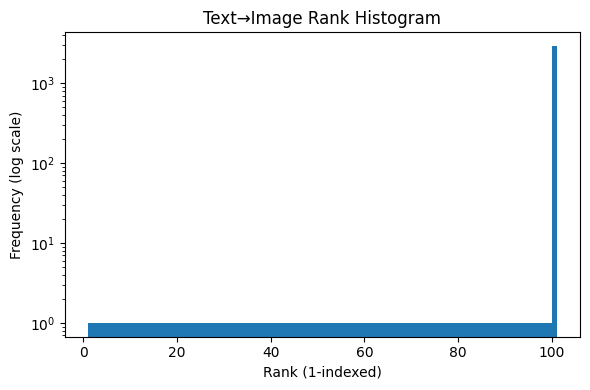

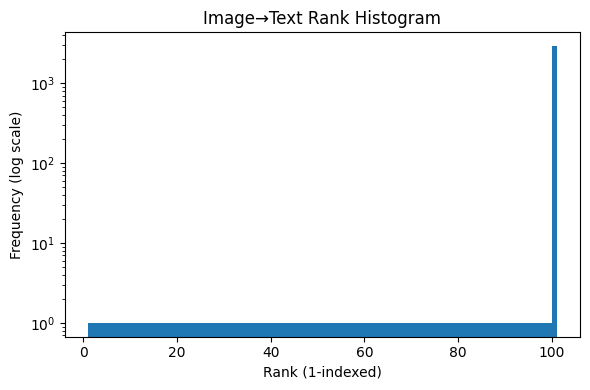

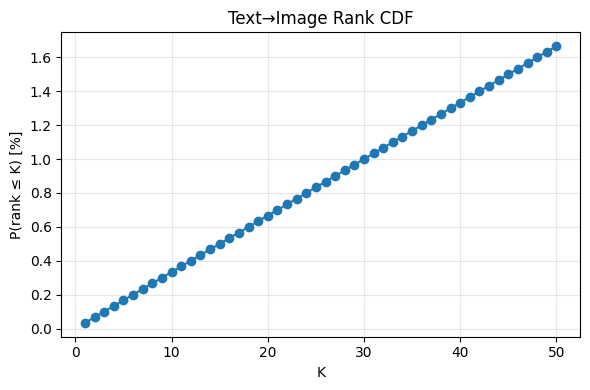

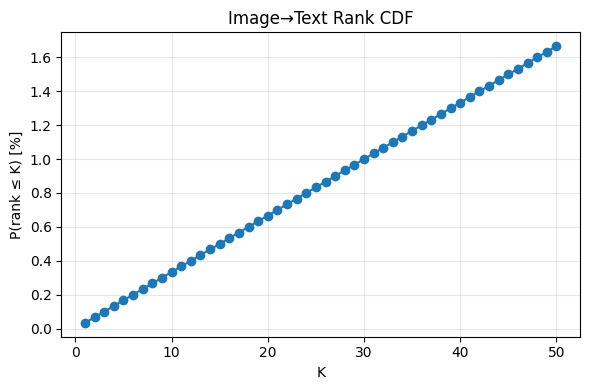

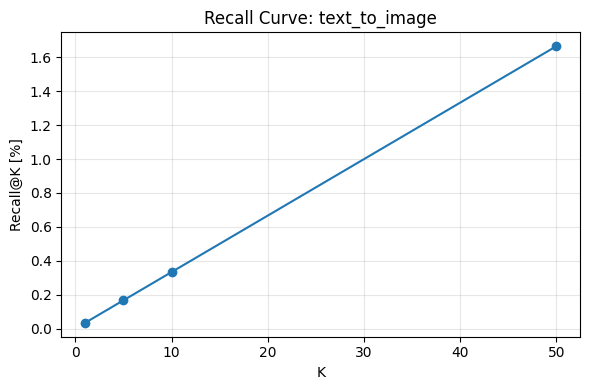

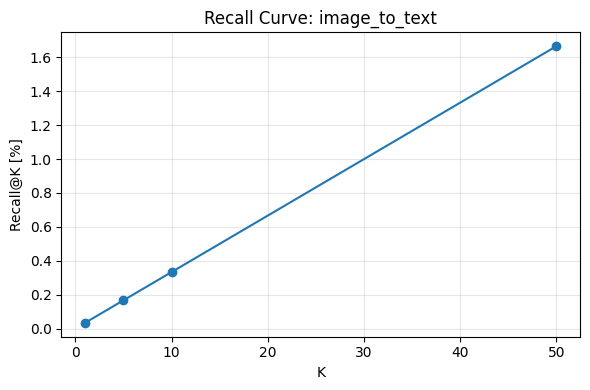

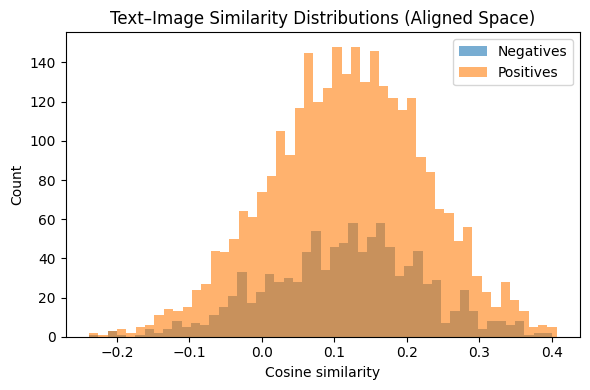

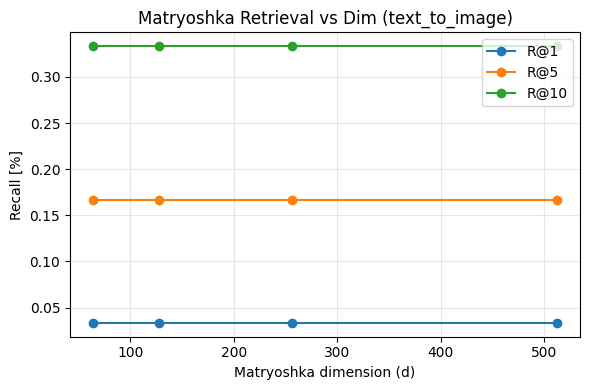

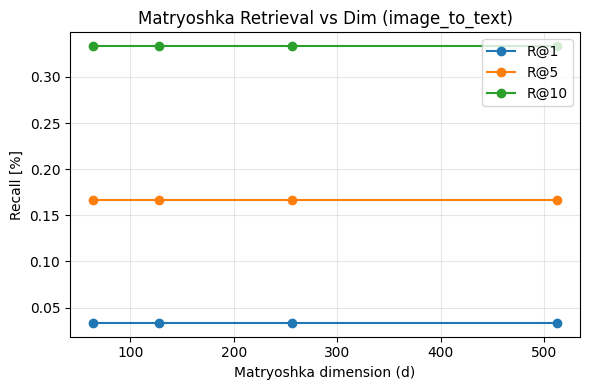

In [20]:
# === Visualize Image–Text Alignment Diagnostics ===

base_prefix = f'{model_kind}/image_text'

# Rank histograms & CDFs
plot_rank_histogram(ranks_t2i, title='Text→Image Rank Histogram')
plot_rank_histogram(ranks_i2t, title='Image→Text Rank Histogram')
plot_rank_cdf(ranks_t2i, title='Text→Image Rank CDF')
plot_rank_cdf(ranks_i2t, title='Image→Text Rank CDF')

# Recall curves
plot_recall_curve(image_text_results, base_prefix, direction='text_to_image')
plot_recall_curve(image_text_results, base_prefix, direction='image_to_text')

# Similarity distributions
plot_similarity_distributions(txt_emb, img_emb, title='Text–Image Similarity Distributions (Aligned Space)')

# Matryoshka curves (if available)
base_prefix = f'{model_kind}/image_text'
plot_mrl_curves(image_text_results, base_prefix, direction='text_to_image')
plot_mrl_curves(image_text_results, base_prefix, direction='image_to_text')

## Summary & Usage

This notebook provides a **comprehensive retrieval evaluation** for Phase‑1 aligned models:

- Works seamlessly for **VisionTextAligner** (image+text) and **MultimodalAlignmentModel** (image+text+audio).
- Evaluates **image↔text retrieval** on PixMo‑Cap from a local Parquet file.
- Optionally evaluates **audio↔text retrieval** if an audio encoder and dataset are present.
- Computes a rich set of metrics: R@K, MR, MedR, mAP@K, NDCG@K, plus Matryoshka curves.
- Produces intuitive plots to interpret alignment quality, inspired by **Freeze‑Align**, **ImageBind** and **Matryoshka**.

**How to use:**

1. Set `EVAL_CKPT_PATH` in the config cell to the checkpoint you want to evaluate.
2. Make sure `PIXMO_PARQUET_PATH` (and optionally `AUDIO_PARQUET_PATH`) point to existing local Parquet files.
3. Run all cells top‑to‑bottom.
4. Inspect the printed metrics, plots, and W&B dashboard for a high‑level picture of alignment quality.

You can reuse this notebook for multiple checkpoints (vision‑text only vs. multimodal MLP vs. multimodal Perceiver)
by simply changing `EVAL_CKPT_PATH` and re‑running.
